In [1]:
%matplotlib inline
import os
import math

import cv2
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
from skimage.feature import hog
import tensorflow as tf
from keras.applications import resnet as Res
from keras.applications import densenet, mobilenet
from keras.layers import *
from keras.models import Model

from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense
from keras import backend as K

from model import Structure

In [2]:
#基于keras构建的深度学习模型，本方法主要采用第二个，基于vgg16作为backbone进行训练
class Structure:
    @staticmethod
    def build(width, height, depth, classes):
        
        model = Sequential()
        input_Shape = (height, width, depth)
        
        if K.image_data_format() == "channels_first":   
            inputShape = (depth, height, width)
        
        model.add(Conv2D(64, (5, 5),padding="same",input_shape=(input_Shape)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
       
        model.add(Conv2D(128, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        model.add(Conv2D(256, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))

       
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model
    
    @staticmethod
    def build_pre(classes=2, train_backbone=True, weights='imagenet'):
        resnet = VGG16(
            input_shape=(224, 224, 3),
            include_top=False,
            weights=weights,
        )
        if weights is not None:
            resnet.trainable = train_backbone

        x = resnet.output
        # x = GlobalAvgPool2D()(x)
        x = GlobalMaxPooling2D()(x)
        # x = Dense(512)(x)
        # x = Dropout(0.3)(x)
        x = Dense(128)(x)
        x = Dropout(0.3)(x)
        x = Dense(16)(x)
        predictions = Dense(classes, activation='softmax')(x)

        return Model(resnet.inputs, predictions)

In [3]:
#载入深度学习模型
model = Structure.build_pre(weights=None)
model.load_weights('./0.9941_0.9706_weights.hdf5')

In [4]:
#载入orb特征点方法
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING)

In [5]:
#ahash和phash算法，最后没用
def aHash(image,leng=8,wid=8):     
    image = cv2.resize(image, (leng,wid))     
    avreage = np.mean(image)      
    hash = []      
    for i in range(image.shape[0]):          
        for j in range(image.shape[1]):              
            if image[i,j] >= avreage:                  
                hash.append(1)              
            else:                  
                hash.append(0)      
    return hash  

def pHash(image,leng=32,wid=32):
    image = cv2.resize(image, (leng,wid))
#     image = np.array(image.resize((leng,wid), Image.ANTIALIAS).convert('L'), 'f')     
    A=[]     
    for i in range(0,32):         
        for j in range(0,32):             
            if i==0:                 
                a=np.sqrt(1/32)             
            else:                 
                a=np.sqrt(2/32)             
            A.append(a*np.cos(np.pi*(2*j+1)*i/(2*32)))     
    dct = np.dot(np.dot(image,np.reshape(A,(32,32))),np.transpose(image))     
    b = dct[0:8][0:8]     
    hash=[]     
    avreage = np.mean(b)     
    for i in range(8):          
        for j in range(8):              
            if b[i,j] >= avreage:                  
                hash.append(1)              
            else:                  
                hash.append(0)     
    return hash   #计算汉明距离 

def Hamming_distance(hash1,hash2):      
    num = 0     
    for index in range(len(hash1)):          
        if hash1[index] != hash2[index]:              
            num += 1     
    return num

#orb特征点比对，通过和base进行对比去除途中复杂的干扰物
def orb_match(img1, img2, min_dist):
    kp1 = orb.detect(img1)
    kp2 = orb.detect(img2)

    kp1, des1 = orb.compute(img1, kp1) 
    kp2, des2 = orb.compute(img2, kp2)

    matches = bf.match(des1, des2)
    if len(matches) == 0:
        return 0, 0
    # min_distance = matches[0].distance
    # max_distance = matches[0].distance
    # for x in matches:
    #     if x.distance < min_distance:
    #         min_distance = x.distance
    #     if x.distance > max_distance:
    #         max_distance = x.distance

    good_match = []
    for x in matches:
        if x.distance <= min_dist:
            good_match.append(x)
           
    return len(good_match), min_distance

In [6]:
#载入4张base图，这里主要针对的是泛化测试进行的去除，考虑到可能还会有其他复杂负样本，后期可以增加
img0 = cv2.imread('./base/0.jpg')
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)

img1 = cv2.imread('./base/1.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

img2 = cv2.imread('./base/2.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

img3 = cv2.imread('./base/3.jpg')
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

In [8]:
#遍历文件夹，读图
for f in tqdm.tqdm(os.listdir('./labels/images/')):
#     print(f)
#     if f != '1_146.jpg':
#         continue
#     if f != '1764_20231026095726_2.jpg':
#         continue
    img = cv2.imread('./labels/images/' + f)
    img_copy = img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #构建sobel算子，计算梯度变换，实际测试中，发现有杂物的梯度应该是处于一个范围的
    x = cv2.Sobel(img, cv2.CV_16S, 1, 0)
    y = cv2.Sobel(img, cv2.CV_16S, 0, 1)
    #做空图，用来和原图合并突出最终判定有杂物的部分
    blank = np.zeros((2048, 2448))
    #分成5*5的格子，依次扫过
    for i in range(5):
        for j in range(5):
            #sobel梯度对结果进行筛选
            if np.max(x[i*409:(i+1)*409, 489*j:(j+1)*489]) > 100 and np.min(x[i*409:(i+1)*409, 489*j:(j+1)*489]) < -90 and \
                np.max(y[i*409:(i+1)*409, 489*j:(j+1)*489]) > 200 and -1000 < np.min(y[i*409:(i+1)*409, 489*j:(j+1)*489]) < -100:
#                 hog_feat, _ = hog(img[i*409:(i+1)*409, 489*j:(j+1)*489], orientations=8, pixels_per_cell=(32, 32), cells_per_block=(8, 8), block_norm='L2-Hys', visualize=True)
                try_img = img[i*409:(i+1)*409, 489*j:(j+1)*489]
#                 hist,_,_ = plt.hist(try_img.ravel(), 3)
                #对顶上的线缆进行去除，有可能有空值，原因未知，所以增加try
                if i == 0:
                    p0_dist, min_d0 = orb_match(img[i*409:(i+1)*409, :], img0, 30)
                    p1_dist, min_d1 = orb_match(img[i*409:(i+1)*409, :], img1, 30)
                else:
                    p0_dist, p1_dist = 0, 0
                #对右边的风扇进行去除
                p2_dist, min_d2 = orb_match(img[:, 489*j:(j+1)*489], img2, 30)
                p3_dist, min_d3 = orb_match(img[:, 489*j:(j+1)*489], img3, 30)
                if p0_dist > 5 or p1_dist > 5 or p2_dist > 5 or p3_dist > 15:
                    continue
#                 if p0_dist > 5 or p1_dist > 5 or p2_dist > 5 or p3_dist > 15:
#                     continue
#                 if hist[2] < hist[1] and (hist[1] > 2000 or hist[2] > 1000):
                #通过深度学习对剩下的部分进行判断
                bgr_image = img_copy[i*409:(i+1)*409, 489*j:(j+1)*489, :]
                img_rgb = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
                rgb_resize = cv2.resize(img_rgb, (224, 224))
                rgb_resize = np.expand_dims(rgb_resize, axis=0)
                rgb_resize = rgb_resize/255.
                pred = model.predict(rgb_resize)
                ind = np.argmax(pred)
                if ind == 0:
                    continue
                #如果依旧符合标准，将空白图上对应的部分图成白色
                blank[i*409:(i+1)*409, 489*j:(j+1)*489] = 255
#                     plt.clf()
#                 if 0 < i < 4 and 0 < j < 4:
#                     bgr_image = img_copy[i*409 - 50:(i+1)*409 +50, 489*j - 50:(j+1)*489 + 50, :]
#                     img_rgb = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
#                     rgb_resize = cv2.resize(img_rgb, (224, 224))
#                     rgb_resize = np.expand_dims(rgb_resize, axis=0)
#                     rgb_resize = rgb_resize/255.
#                     pred = model.predict(rgb_resize)
#                     ind = np.argmax(pred)
#                     if ind == 1:
#                         blank[i*409 - 50:(i+1)*409 +50, 489*j - 50:(j+1)*489 + 50] = 255
#                 print(pred)
#                 cv2.putText(blank, str(pred[0][0]), (10+j*489, 204+i*409), cv2.FONT_HERSHEY_COMPLEX, 2, (255, 255, 255), 5)
#                 cv2.putText(blank, str(pred[0][1]), (j*489, 234+i*409), cv2.FONT_HERSHEY_COMPLEX, 2, (255, 255, 255), 5)

#                         if ind == 0:
#                             continue
#                         blank[i*409:(i+1)*409, 489*j:(j+1)*489] = 255
#                 cv2.imwrite('./images/images/' + f[:-4] + '_' + str(i) + '_' + str(j) + '.jpg', img_copy[i*409:(i+1)*409, 489*j:(j+1)*489])
#                 plt.clf()
    blank = cv2.convertScaleAbs(blank)
    #将白板和原图进行合并，显示有杂物的部分
    dst = cv2.addWeighted(img, 0.5, blank, 0.5, 0)
#     plt.imshow(dst)
    cv2.imwrite('./result/' + f, dst)


  0%|                                                                                         | 0/1198 [00:00<?, ?it/s]

1/1 [==============================] - 0s 240ms/step



  0%|                                                                               | 1/1198 [00:09<3:16:36,  9.86s/it]

1/1 [==============================] - 0s 228ms/step



  0%|▏                                                                              | 2/1198 [00:17<2:44:42,  8.26s/it]

1/1 [==============================] - 0s 240ms/step



  0%|▏                                                                              | 3/1198 [00:24<2:36:43,  7.87s/it]

1/1 [==============================] - 0s 212ms/step



  0%|▎                                                                              | 4/1198 [00:32<2:39:13,  8.00s/it]

1/1 [==============================] - 0s 201ms/step



  0%|▎                                                                              | 5/1198 [00:40<2:36:16,  7.86s/it]

1/1 [==============================] - 0s 201ms/step



  1%|▍                                                                              | 6/1198 [00:42<1:59:33,  6.02s/it]

1/1 [==============================] - 0s 206ms/step



  1%|▍                                                                              | 7/1198 [00:50<2:10:44,  6.59s/it]

1/1 [==============================] - 0s 201ms/step



  1%|▌                                                                              | 8/1198 [00:58<2:18:30,  6.98s/it]

1/1 [==============================] - 0s 201ms/step



  1%|▌                                                                              | 9/1198 [01:06<2:25:54,  7.36s/it]

1/1 [==============================] - 0s 205ms/step



  1%|▋                                                                             | 10/1198 [01:13<2:25:53,  7.37s/it]

1/1 [==============================] - 0s 243ms/step



  1%|▋                                                                             | 11/1198 [01:22<2:35:37,  7.87s/it]

1/1 [==============================] - 0s 222ms/step



  1%|▊                                                                             | 12/1198 [01:28<2:24:09,  7.29s/it]

1/1 [==============================] - 0s 211ms/step



  1%|▊                                                                             | 13/1198 [01:35<2:21:24,  7.16s/it]

1/1 [==============================] - 0s 210ms/step



  1%|▉                                                                             | 14/1198 [01:44<2:29:25,  7.57s/it]

1/1 [==============================] - 0s 204ms/step



  1%|▉                                                                             | 15/1198 [01:52<2:34:47,  7.85s/it]

1/1 [==============================] - 0s 220ms/step



  1%|█                                                                             | 16/1198 [01:56<2:13:07,  6.76s/it]

1/1 [==============================] - 0s 212ms/step



  1%|█                                                                             | 17/1198 [02:07<2:33:53,  7.82s/it]

1/1 [==============================] - 0s 219ms/step



  2%|█▏                                                                            | 18/1198 [02:16<2:41:24,  8.21s/it]

1/1 [==============================] - 0s 207ms/step



  2%|█▏                                                                            | 19/1198 [02:23<2:33:47,  7.83s/it]

1/1 [==============================] - 0s 214ms/step



  2%|█▎                                                                            | 20/1198 [02:30<2:28:52,  7.58s/it]

1/1 [==============================] - 0s 207ms/step



  2%|█▎                                                                            | 21/1198 [02:40<2:42:07,  8.26s/it]

1/1 [==============================] - 0s 230ms/step



  2%|█▍                                                                            | 22/1198 [02:50<2:55:51,  8.97s/it]

1/1 [==============================] - 0s 243ms/step



  2%|█▍                                                                            | 23/1198 [03:00<3:01:04,  9.25s/it]

1/1 [==============================] - 0s 252ms/step



  2%|█▌                                                                            | 24/1198 [03:08<2:54:19,  8.91s/it]

1/1 [==============================] - 0s 227ms/step



  2%|█▋                                                                            | 25/1198 [03:16<2:44:43,  8.43s/it]

1/1 [==============================] - 0s 209ms/step



  2%|█▋                                                                            | 26/1198 [03:20<2:23:29,  7.35s/it]

1/1 [==============================] - 0s 206ms/step



  2%|█▊                                                                            | 27/1198 [03:29<2:28:39,  7.62s/it]

1/1 [==============================] - 0s 234ms/step



  2%|█▊                                                                            | 28/1198 [03:36<2:27:34,  7.57s/it]

1/1 [==============================] - 0s 213ms/step



  2%|█▉                                                                            | 29/1198 [03:44<2:28:38,  7.63s/it]

1/1 [==============================] - 0s 211ms/step



  3%|█▉                                                                            | 30/1198 [03:51<2:26:11,  7.51s/it]

1/1 [==============================] - 0s 208ms/step



  3%|██                                                                            | 31/1198 [03:56<2:12:12,  6.80s/it]

1/1 [==============================] - 0s 217ms/step



  3%|██                                                                            | 32/1198 [04:06<2:27:18,  7.58s/it]

1/1 [==============================] - 0s 202ms/step



  3%|██▏                                                                           | 33/1198 [04:12<2:19:39,  7.19s/it]

1/1 [==============================] - 0s 202ms/step



  3%|██▏                                                                           | 34/1198 [04:18<2:15:49,  7.00s/it]

1/1 [==============================] - 0s 224ms/step



  3%|██▎                                                                           | 35/1198 [04:29<2:35:59,  8.05s/it]

1/1 [==============================] - 0s 201ms/step



  3%|██▎                                                                           | 36/1198 [04:37<2:35:17,  8.02s/it]

1/1 [==============================] - 0s 214ms/step



  3%|██▍                                                                           | 37/1198 [04:45<2:36:51,  8.11s/it]

1/1 [==============================] - 0s 199ms/step



  3%|██▍                                                                           | 38/1198 [04:53<2:37:31,  8.15s/it]

1/1 [==============================] - 0s 205ms/step



  3%|██▌                                                                           | 39/1198 [05:01<2:35:15,  8.04s/it]

1/1 [==============================] - 0s 224ms/step



  3%|██▌                                                                           | 40/1198 [05:05<2:08:52,  6.68s/it]

1/1 [==============================] - 0s 234ms/step



  3%|██▋                                                                           | 41/1198 [05:16<2:35:19,  8.06s/it]

1/1 [==============================] - 0s 221ms/step



  4%|██▋                                                                           | 42/1198 [05:27<2:51:34,  8.91s/it]

1/1 [==============================] - 0s 222ms/step



  4%|██▊                                                                           | 43/1198 [05:33<2:34:32,  8.03s/it]

1/1 [==============================] - 0s 205ms/step



  4%|██▊                                                                           | 44/1198 [05:37<2:13:12,  6.93s/it]

1/1 [==============================] - 0s 223ms/step



  4%|██▉                                                                           | 45/1198 [05:47<2:30:10,  7.81s/it]

1/1 [==============================] - 0s 201ms/step



  4%|██▉                                                                           | 46/1198 [05:56<2:36:44,  8.16s/it]

1/1 [==============================] - 0s 216ms/step



  4%|███                                                                           | 47/1198 [06:03<2:32:13,  7.94s/it]

1/1 [==============================] - 0s 211ms/step



  4%|███▏                                                                          | 48/1198 [06:13<2:40:26,  8.37s/it]

1/1 [==============================] - 0s 210ms/step



  4%|███▏                                                                          | 49/1198 [06:23<2:47:32,  8.75s/it]

1/1 [==============================] - 0s 231ms/step



  4%|███▎                                                                          | 50/1198 [06:27<2:22:24,  7.44s/it]

1/1 [==============================] - 0s 250ms/step



  4%|███▎                                                                          | 51/1198 [06:34<2:22:48,  7.47s/it]

1/1 [==============================] - 0s 203ms/step



  4%|███▍                                                                          | 52/1198 [06:43<2:30:10,  7.86s/it]

1/1 [==============================] - 0s 212ms/step



  4%|███▍                                                                          | 53/1198 [06:50<2:26:27,  7.67s/it]

1/1 [==============================] - 0s 207ms/step



  5%|███▌                                                                          | 54/1198 [06:59<2:31:32,  7.95s/it]

1/1 [==============================] - 0s 209ms/step



  5%|███▌                                                                          | 55/1198 [07:05<2:17:28,  7.22s/it]

1/1 [==============================] - 0s 230ms/step



  5%|███▋                                                                          | 56/1198 [07:12<2:18:27,  7.27s/it]

1/1 [==============================] - 0s 202ms/step



  5%|███▋                                                                          | 57/1198 [07:16<2:00:32,  6.34s/it]

1/1 [==============================] - 0s 235ms/step



  5%|███▊                                                                          | 58/1198 [07:24<2:07:12,  6.69s/it]

1/1 [==============================] - 0s 200ms/step



  5%|███▊                                                                          | 59/1198 [07:27<1:49:02,  5.74s/it]

1/1 [==============================] - 0s 204ms/step



  5%|███▉                                                                          | 60/1198 [07:37<2:13:23,  7.03s/it]

1/1 [==============================] - 0s 211ms/step



  5%|███▉                                                                          | 61/1198 [07:43<2:08:30,  6.78s/it]

1/1 [==============================] - 0s 208ms/step



  5%|████                                                                          | 62/1198 [07:53<2:22:06,  7.51s/it]

1/1 [==============================] - 0s 214ms/step



  5%|████                                                                          | 63/1198 [07:59<2:15:52,  7.18s/it]

1/1 [==============================] - 0s 227ms/step



  5%|████▏                                                                         | 64/1198 [08:08<2:27:54,  7.83s/it]

1/1 [==============================] - 0s 206ms/step



  5%|████▏                                                                         | 65/1198 [08:14<2:13:01,  7.04s/it]

1/1 [==============================] - 0s 200ms/step



  6%|████▎                                                                         | 66/1198 [08:22<2:19:23,  7.39s/it]

1/1 [==============================] - 0s 198ms/step



  6%|████▎                                                                         | 67/1198 [08:30<2:24:47,  7.68s/it]

1/1 [==============================] - 0s 200ms/step



  6%|████▍                                                                         | 68/1198 [08:36<2:15:13,  7.18s/it]

1/1 [==============================] - 0s 189ms/step



  6%|████▍                                                                         | 69/1198 [08:40<1:56:36,  6.20s/it]

1/1 [==============================] - 0s 242ms/step



  6%|████▌                                                                         | 70/1198 [08:47<2:00:34,  6.41s/it]

1/1 [==============================] - 0s 224ms/step



  6%|████▌                                                                         | 71/1198 [08:54<2:02:58,  6.55s/it]

1/1 [==============================] - 0s 224ms/step



  6%|████▋                                                                         | 72/1198 [09:00<2:00:57,  6.45s/it]

1/1 [==============================] - 0s 205ms/step



  6%|████▊                                                                         | 73/1198 [09:07<2:05:21,  6.69s/it]

1/1 [==============================] - 0s 213ms/step



  6%|████▊                                                                         | 74/1198 [09:14<2:04:18,  6.64s/it]

1/1 [==============================] - 0s 219ms/step



  6%|████▉                                                                         | 75/1198 [09:22<2:12:34,  7.08s/it]

1/1 [==============================] - 0s 249ms/step



  6%|████▉                                                                         | 76/1198 [09:29<2:11:00,  7.01s/it]

1/1 [==============================] - 0s 196ms/step



  6%|█████                                                                         | 77/1198 [09:37<2:18:44,  7.43s/it]

1/1 [==============================] - 0s 201ms/step



  7%|█████                                                                         | 78/1198 [09:45<2:21:47,  7.60s/it]

1/1 [==============================] - 0s 198ms/step



  7%|█████▏                                                                        | 79/1198 [09:51<2:14:14,  7.20s/it]

1/1 [==============================] - 0s 204ms/step



  7%|█████▏                                                                        | 80/1198 [10:02<2:35:41,  8.36s/it]

1/1 [==============================] - 0s 247ms/step



  7%|█████▎                                                                        | 81/1198 [10:10<2:31:32,  8.14s/it]

1/1 [==============================] - 0s 237ms/step



  7%|█████▎                                                                        | 82/1198 [10:18<2:30:09,  8.07s/it]

1/1 [==============================] - 0s 211ms/step



  7%|█████▍                                                                        | 83/1198 [10:28<2:39:14,  8.57s/it]

1/1 [==============================] - 0s 239ms/step



  7%|█████▍                                                                        | 84/1198 [10:34<2:28:15,  7.98s/it]

1/1 [==============================] - 0s 239ms/step



  7%|█████▌                                                                        | 85/1198 [10:40<2:15:41,  7.31s/it]

1/1 [==============================] - 0s 228ms/step



  7%|█████▌                                                                        | 86/1198 [10:49<2:21:40,  7.64s/it]

1/1 [==============================] - 0s 233ms/step



  7%|█████▋                                                                        | 87/1198 [10:56<2:20:47,  7.60s/it]

1/1 [==============================] - 0s 254ms/step



  7%|█████▋                                                                        | 88/1198 [11:03<2:19:47,  7.56s/it]

1/1 [==============================] - 0s 232ms/step



  7%|█████▊                                                                        | 89/1198 [11:09<2:08:40,  6.96s/it]

1/1 [==============================] - 0s 215ms/step



  8%|█████▊                                                                        | 90/1198 [11:16<2:05:50,  6.81s/it]

1/1 [==============================] - 0s 216ms/step



  8%|█████▉                                                                        | 91/1198 [11:21<2:00:43,  6.54s/it]

1/1 [==============================] - 0s 213ms/step



  8%|█████▉                                                                        | 92/1198 [11:29<2:08:55,  6.99s/it]

1/1 [==============================] - 0s 265ms/step



  8%|██████                                                                        | 93/1198 [11:39<2:20:02,  7.60s/it]

1/1 [==============================] - 0s 218ms/step



  8%|██████                                                                        | 94/1198 [11:46<2:21:13,  7.68s/it]

1/1 [==============================] - 0s 253ms/step



  8%|██████▏                                                                       | 95/1198 [11:57<2:36:21,  8.51s/it]

1/1 [==============================] - 0s 220ms/step



  8%|██████▎                                                                       | 96/1198 [12:06<2:42:20,  8.84s/it]

1/1 [==============================] - 0s 247ms/step



  8%|██████▎                                                                       | 97/1198 [12:15<2:41:50,  8.82s/it]

1/1 [==============================] - 0s 223ms/step



  8%|██████▍                                                                       | 98/1198 [12:24<2:44:08,  8.95s/it]

1/1 [==============================] - 0s 239ms/step



  8%|██████▍                                                                       | 99/1198 [12:34<2:44:35,  8.99s/it]

1/1 [==============================] - 0s 240ms/step



  8%|██████▍                                                                      | 100/1198 [12:40<2:29:18,  8.16s/it]

1/1 [==============================] - 0s 233ms/step



  8%|██████▍                                                                      | 101/1198 [12:52<2:53:45,  9.50s/it]

1/1 [==============================] - 0s 224ms/step



  9%|██████▌                                                                      | 102/1198 [13:01<2:48:55,  9.25s/it]

1/1 [==============================] - 0s 257ms/step



  9%|██████▌                                                                      | 103/1198 [13:08<2:34:09,  8.45s/it]

1/1 [==============================] - 0s 200ms/step



  9%|██████▋                                                                      | 104/1198 [13:15<2:30:33,  8.26s/it]

1/1 [==============================] - 0s 238ms/step



  9%|██████▋                                                                      | 105/1198 [13:22<2:18:34,  7.61s/it]

1/1 [==============================] - 0s 246ms/step



  9%|██████▊                                                                      | 106/1198 [13:29<2:18:13,  7.60s/it]

1/1 [==============================] - 0s 226ms/step



  9%|██████▉                                                                      | 107/1198 [13:36<2:15:41,  7.46s/it]

1/1 [==============================] - 0s 224ms/step



  9%|██████▉                                                                      | 108/1198 [13:46<2:28:11,  8.16s/it]

1/1 [==============================] - 0s 228ms/step



  9%|███████                                                                      | 109/1198 [13:54<2:27:36,  8.13s/it]

1/1 [==============================] - 0s 228ms/step



  9%|███████                                                                      | 110/1198 [14:02<2:26:02,  8.05s/it]

1/1 [==============================] - 0s 224ms/step



  9%|███████▏                                                                     | 111/1198 [14:14<2:45:34,  9.14s/it]

1/1 [==============================] - 0s 277ms/step



  9%|███████▏                                                                     | 112/1198 [14:20<2:30:49,  8.33s/it]

1/1 [==============================] - 0s 381ms/step



  9%|███████▎                                                                     | 113/1198 [14:30<2:40:36,  8.88s/it]

1/1 [==============================] - 0s 250ms/step



 10%|███████▎                                                                     | 114/1198 [14:36<2:25:43,  8.07s/it]

1/1 [==============================] - 0s 254ms/step



 10%|███████▍                                                                     | 115/1198 [14:42<2:13:59,  7.42s/it]

1/1 [==============================] - 0s 206ms/step


 10%|███████▍                                                                     | 115/1198 [14:51<2:19:52,  7.75s/it]

KeyboardInterrupt



In [40]:
example = cv2.imread('./images/images/1758_20231024151201_3_0_4.jpg')

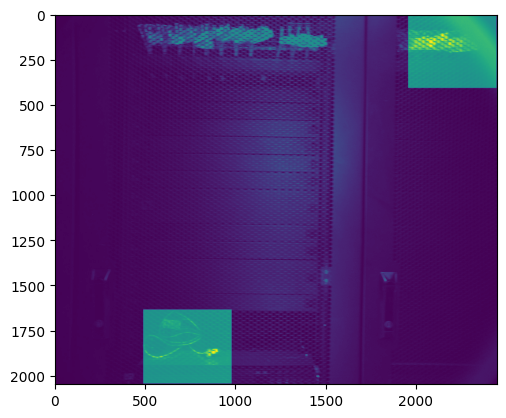

In [41]:
plt.imshow(dst)

In [ ]:
plt.imshow()

In [143]:
np.min(x[250:500, 1000:1500])

-136

In [144]:
np.min(y[250:500, 1000:1500])

-432

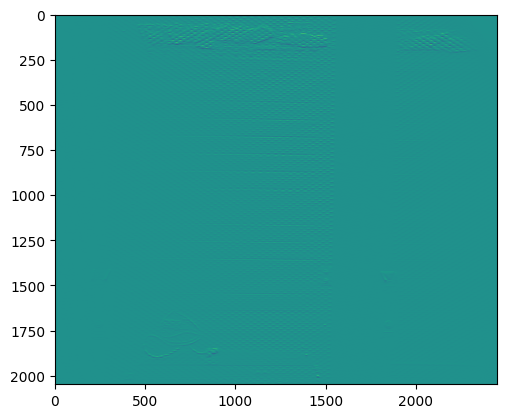

In [129]:
plt.imshow(y)

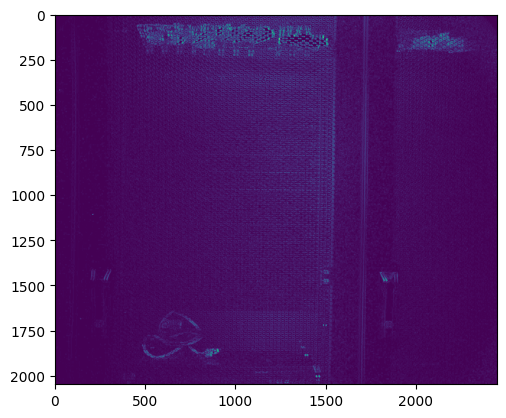

In [108]:
plt.imshow(absX)

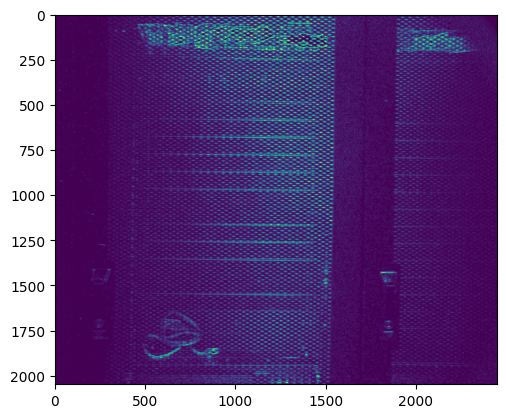

In [109]:
plt.imshow(absY)

In [69]:
z1 = np.where(x > 40, 255, 0)
# z1 = np.where(z1 > 50, 255, 0)
absX = cv2.convertScaleAbs(z1)

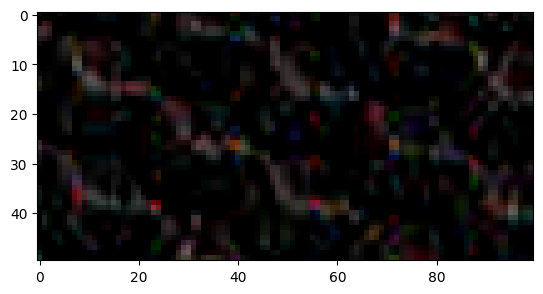

In [58]:
plt.imshow(z1[250:300, 1000:1100])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


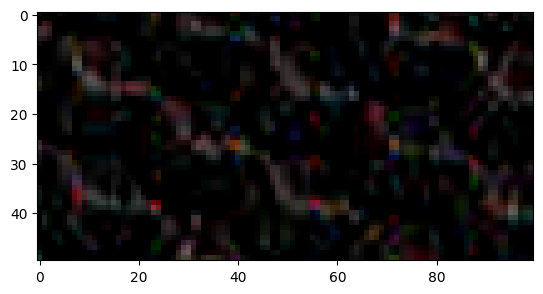

In [59]:
plt.imshow(x[250:300, 1000:1100])

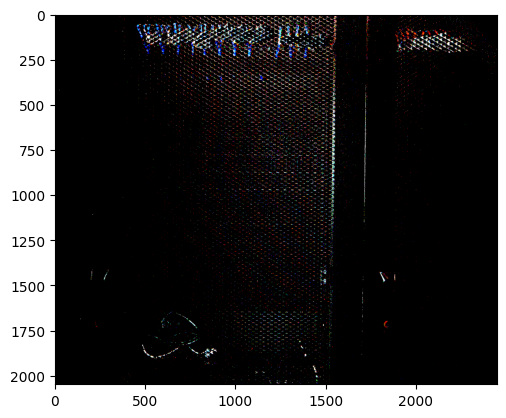

In [70]:
plt.imshow(absX)

In [81]:
z2 = np.where(y > 100, 255, 0)
# z2 = np.where(z2 > 25, 255, z2)
absY = cv2.convertScaleAbs(z2)

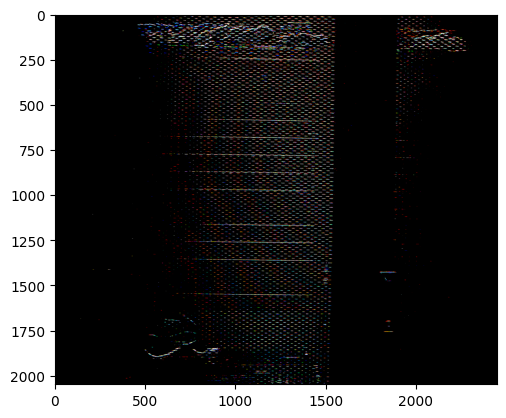

In [83]:
plt.imshow(absY)

In [75]:
dst = cv2.addWeighted(absX, 0.5, absY, 0.5, 0)

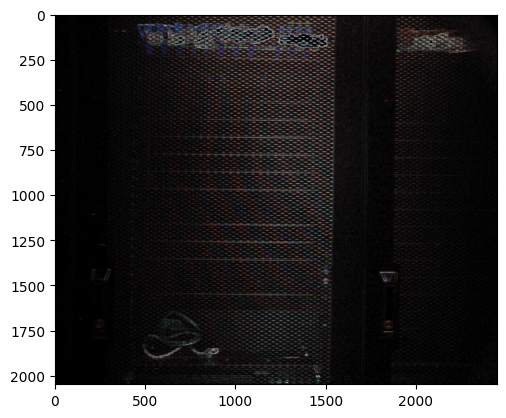

In [76]:
plt.imshow(dst)

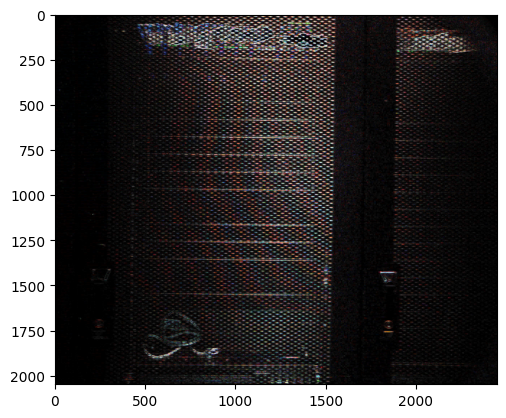

In [78]:
plt.imshow(absY)

In [80]:
absY[250:300, 1000:1100]

array([[[ 63,   5,  27],
        [ 78,   1,  28],
        [104,  14,  13],
        ...,
        [213,  88, 108],
        [223,  96, 116],
        [225, 102, 121]],

       [[255, 163, 168],
        [255, 162, 170],
        [255, 189, 200],
        ...,
        [164,  75,  90],
        [169,  86,  99],
        [173,  95, 107]],

       [[251, 186, 214],
        [255, 234, 255],
        [255, 255, 255],
        ...,
        [ 22,   2,   2],
        [ 20,   4,   8],
        [ 24,  15,  18]],

       ...,

       [[246, 152, 133],
        [247, 162, 142],
        [252, 173, 152],
        ...,
        [  1,   7,  34],
        [  3,   3,  14],
        [  0,   8,   2]],

       [[237, 255, 233],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  8,   7,  14],
        [ 10,  17,   0],
        [  7,  21,  12]],

       [[139,  30,   2],
        [109,  53,  26],
        [ 62,  86,  62],
        ...,
        [ 15,  27,  19],
        [ 14,  28,  23],
        [ 13,  27,  25]]